**ANN LSTM univariate model for the prediction of meteorological time series data.**

**LSTM for forecasting**
*Code used and adapted from reference:*  **https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing**



# **IMPORT LIBRARIES**

In [ ]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, InputLayer, Dropout, Bidirectional
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

# **DATA MANIPULATION**

In [ ]:
#--- LOAD DATA ---#
location = 'TIME-SERIES-Diario-13-23.csv'  ## DAILY DATA
# location = 'TIME-SERIES-Mensual-86-23.csv' ## MONTHLY DATA

data = pd.read_csv(location, parse_dates=['Fecha']) # PARSE COLUMN "FECHA" TO DATE TYPE
data = data.set_index(['Fecha']) # SET INDEX
data.head()

,Año,Mes,Dia,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
Fecha,,,,,,,,
2013-01-01,2013,Ene,1,12.038,18.022,7.344,0.956,73.676
2013-01-02,2013,Ene,2,12.224,18.000,8.078,3.600,74.553
2013-01-03,2013,Ene,3,11.902,17.822,7.667,9.933,76.719
2013-01-04,2013,Ene,4,10.906,16.778,7.122,8.800,79.117
2013-01-05,2013,Ene,5,11.146,16.267,7.211,4.956,79.746


In [ ]:
# RENAME COLUMN NAMES
data = data.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad"})

In [ ]:
#--- SELECT TARGET VARIABLE ---#
# DROP COLUMNS THAT ARE NOT GOING TO BE USED
# We are dropping all columns except 'Temp_max' to isolate the target variable.
data = data.drop(["Año", "Dia", "Mes", "Temp_media", "Humedad", "Precipitacion", "Temp_min"], axis=1) # DAILY MAXIMUM TEMPERATURE DATA FRAME
# data = data.drop(["Año", "Mes", "Temp_media", "Humedad", "Temp_min", "Precipitacion"], axis=1)# # MONTHLY MAXIMUM TEMPERATURE DATA FRAME

# Display the first few rows of the dataframe after dropping columns
data.head()

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000
2013-01-03,17.822
2013-01-04,16.778
2013-01-05,16.267


In [ ]:
## SET NAME OF THE TARGET VARIABLE
temp = data["Temp_max"]
temp.head()

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000
2013-01-03,17.822
2013-01-04,16.778
2013-01-05,16.267


In [ ]:
#Check for null values
temp.isnull().any()

np.False_

In [ ]:
# DROP NULL VALUES
temp.dropna(inplace=True)

In [ ]:
# DATA SET INFORMATION
temp.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3883 entries, 2013-01-01 to 2023-08-19
Series name: Temp_max
Non-Null Count  Dtype  
--------------  -----  
3883 non-null   float64
dtypes: float64(1)
memory usage: 60.7 KB


## **TRANSFORM DATA**

In [ ]:
temp_samples = len(temp)

In [ ]:
# Normalización
scaler = MinMaxScaler()
temp_scaled = scaler.fit_transform(temp.values.reshape(-1, 1))
temp_scaled

array([[0.63608466],
       [0.63492063],
       [0.62550265],
       ...,
       [0.66772487],
       [0.62592593],
       [0.65502646]])

# **FEATURE ENGINEERING**

In [ ]:
#@title CREATE WINDOW SIZE (LAGS)
# CREATE SLIDING WINDOWS
def df_to_X_y(df, window_size=3):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

*window_size* : Este parámetro define el número de pasos de tiempo anteriores que el modelo usará para predecir el siguiente valor. Es crucial porque determina cuánta información histórica el modelo considera para hacer una predicción.

In [ ]:
WINDOW_SIZE = 3  ## SET NUMBER OF WINDOWS SLIDES
X1, y1 = df_to_X_y(temp_scaled, WINDOW_SIZE)
X1.shape, y1.shape

((3880, 3, 1, 1), (3880, 1))

# **DATA PREPARATION**

## **SPLIT DATA**

In [ ]:
# CALCULATE SIZE
test_size = int(temp_samples * 0.2)  # 20% TEST
train_val_size = temp_samples - test_size  # 80% TRAIN + VALIDATION

# SPLIT IN TRAIN + VALIDATION AND TEST
X_train_val, y_train_val = X1[:train_val_size], y1[:train_val_size]
X_test1, y_test1 = X1[train_val_size:], y1[train_val_size:]

In [ ]:
# Ahora dividir el conjunto de entrenamiento + validación
# Supongamos que el 10% de los datos totales son para validación (o el 12.5% del conjunto de entrenamiento + validación)
validation_fraction = 0.125
val_size = int(train_val_size * validation_fraction)

# División en entrenamiento y validación
X_train1, y_train1 = X_train_val[:-val_size], y_train_val[:-val_size]
X_val1, y_val1 = X_train_val[-val_size:], y_train_val[-val_size:]

# Verificar formas de los conjuntos
print(f"Training set shape: {X_train1.shape, y_train1.shape}")
print(f"Validation set shape: {X_val1.shape, y_val1.shape}")
print(f"Test set shape: {X_test1.shape, y_test1.shape}")

Training set shape: ((2719, 3, 1, 1), (2719, 1))
Validation set shape: ((388, 3, 1, 1), (388, 1))
Test set shape: ((773, 3, 1, 1), (773, 1))


# **MODEL BUILD**

## **Model architecture**

In [ ]:
## CHANGE PARAMETERS (ADD LAYERS, NEURONS OR TYPE)
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dropout(0.3))  # Added Dropout after LSTM
model1.add(Dense(8, 'relu'))
model1.add(Dropout(0.3))  # Added Dropout after the first Dense layer
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Compile Model
cp1 = ModelCheckpoint('model1/a.keras', save_best_only=True) ## saev the best model of the validation
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()])  # learning_rate , the faster the model create the clusters

In [ ]:
#@title Train LSTM Model
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.4236 - mean_absolute_error: 0.6409 - mean_absolute_percentage_error: 102.4266 - root_mean_squared_error: 0.6508 - val_loss: 0.3997 - val_mean_absolute_error: 0.6225 - val_mean_absolute_percentage_error: 96.5144 - val_root_mean_squared_error: 0.6322
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3673 - mean_absolute_error: 0.5957 - mean_absolute_percentage_error: 94.5478 - root_mean_squared_error: 0.6060 - val_loss: 0.3278 - val_mean_absolute_error: 0.5622 - val_mean_absolute_percentage_error: 86.9039 - val_root_mean_squared_error: 0.5725
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2967 - mean_absolute_error: 0.5313 - mean_absolute_percentage_error: 84.1436 - root_mean_squared_error: 0.5446 - val_loss: 0.2476 - val_mean_absolute_error: 0.4863 - val_mean_absolute_percentage_error: 74.8048 - val_root_mean_squared_error: 0.4976
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2244 - mean_a

In [ ]:
# from tensorflow.keras.models import load_model
# model1 = load_model('model1/')  ###

## MODEL PREDICTION

In [ ]:
train_predictions = model1.predict(X_train1).flatten()

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
# Desescalar las predicciones
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
y_train_actual = scaler.inverse_transform(y_train1.reshape(-1, 1)).flatten()

### TRAIN RESULTS

In [ ]:
# Resultados de entrenamiento
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train_actual})
train_results

,Train Predictions,Actuals
0,15.985059,16.778
1,15.895354,16.267
2,15.751753,17.522
3,15.692751,17.922
4,15.780620,17.967
...,...,...
2714,15.971962,18.000
2715,16.209864,19.100
2716,16.188925,18.900
2717,16.155596,19.400


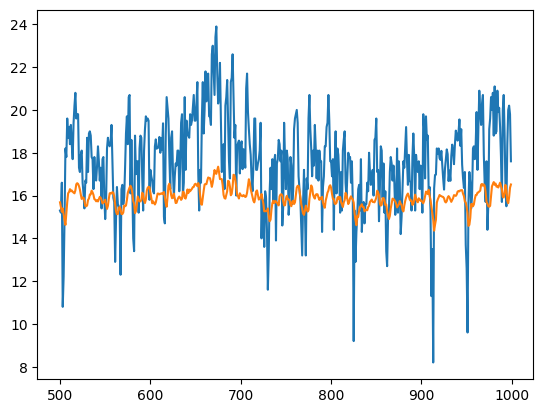

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Actuals'][500:1000])
plt.plot(train_results['Train Predictions'][500:1000])

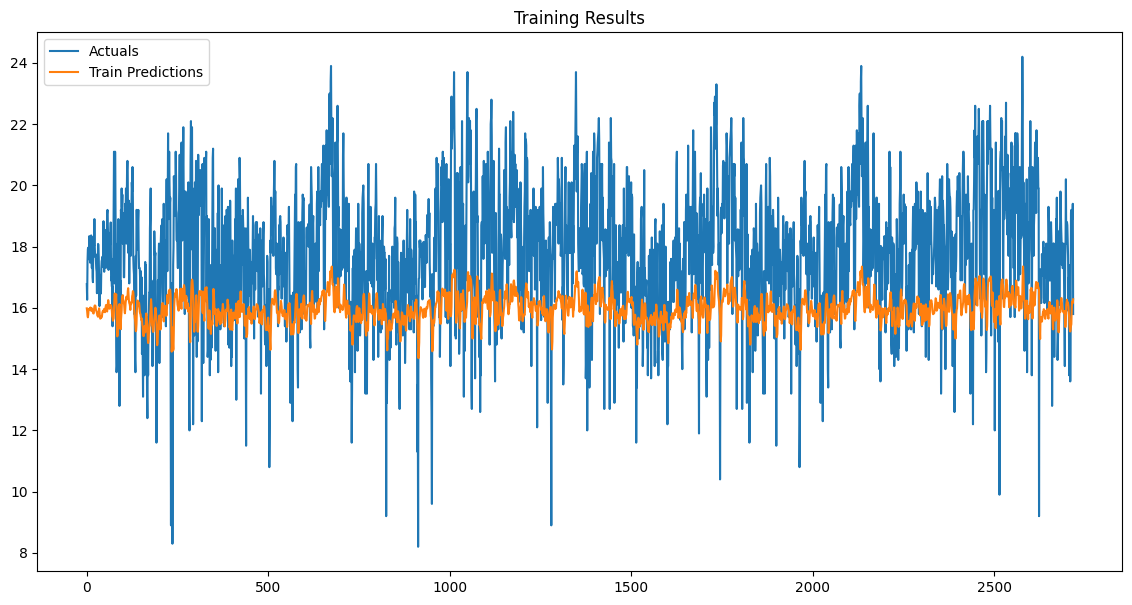

In [ ]:
# Graficar resultados de entrenamiento
plt.figure(figsize=(14, 7))
plt.plot(train_results['Actuals'], label='Actuals')
plt.plot(train_results['Train Predictions'], label='Train Predictions')
plt.title('Training Results')
plt.legend()
plt.show()

### VALIDATION RESULTS

In [ ]:
# Predicciones en conjunto de validación
val_predictions = model1.predict(X_val1).flatten()
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
y_val_actual = scaler.inverse_transform(y_val1.reshape(-1, 1)).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# Resultados de validación
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals': y_val_actual})
val_results

,Val Predictions,Actuals
0,16.055130,14.6
1,15.704572,18.2
2,15.501931,19.8
3,15.808922,20.9
4,16.378578,19.3
...,...,...
383,15.987449,17.6
384,15.968469,18.6
385,15.991491,18.8
386,16.064919,17.9


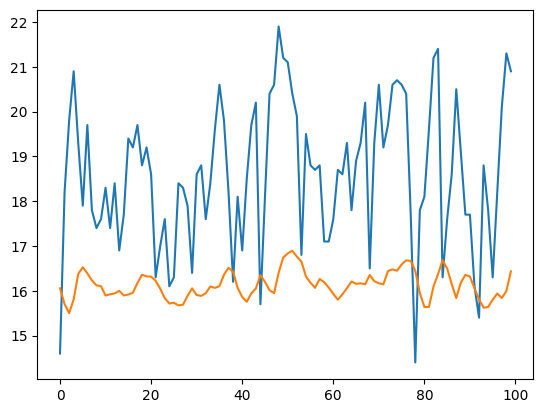

In [ ]:
plt.plot(val_results['Actuals'][:100])
plt.plot(val_results['Val Predictions'][:100])

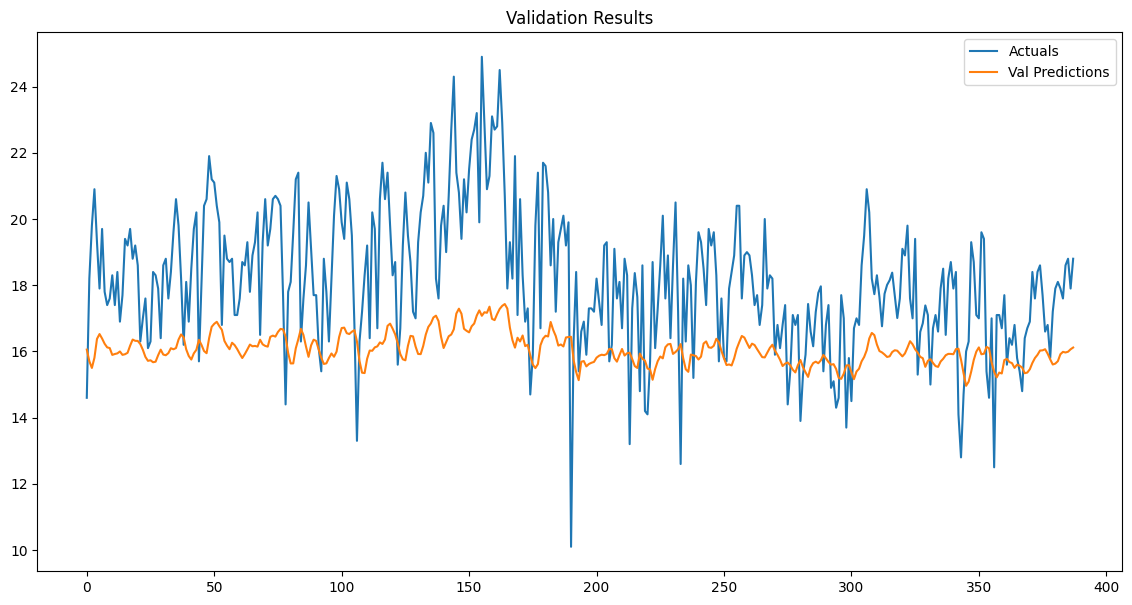

In [ ]:
# Graficar resultados de validación
plt.figure(figsize=(14, 7))
plt.plot(val_results['Actuals'], label='Actuals')
plt.plot(val_results['Val Predictions'], label='Val Predictions')
plt.title('Validation Results')
plt.legend()
plt.show()

### TEST RESULTS

In [ ]:
# Predicciones en conjunto de prueba
test_predictions = model1.predict(X_test1).flatten()
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test1.reshape(-1, 1)).flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Resultados de prueba
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test_actual})
test_results

,Test Predictions,Actuals
0,16.119812,17.70
1,16.035738,19.20
2,16.129787,19.70
3,16.190931,15.20
4,16.069624,17.70
...,...,...
768,15.881608,18.84
769,15.945922,19.06
770,16.082880,18.62
771,16.215010,17.83


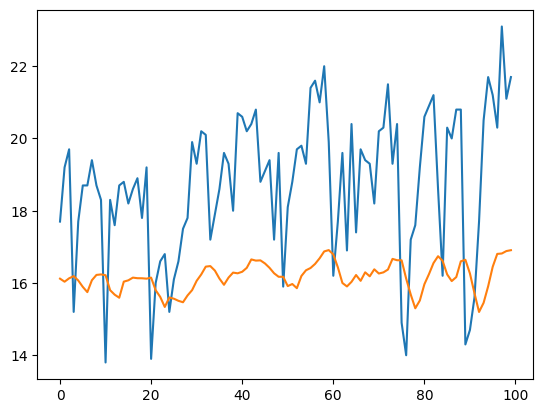

In [ ]:
plt.plot(test_results['Actuals'][:100])
plt.plot(test_results['Test Predictions'][:100])

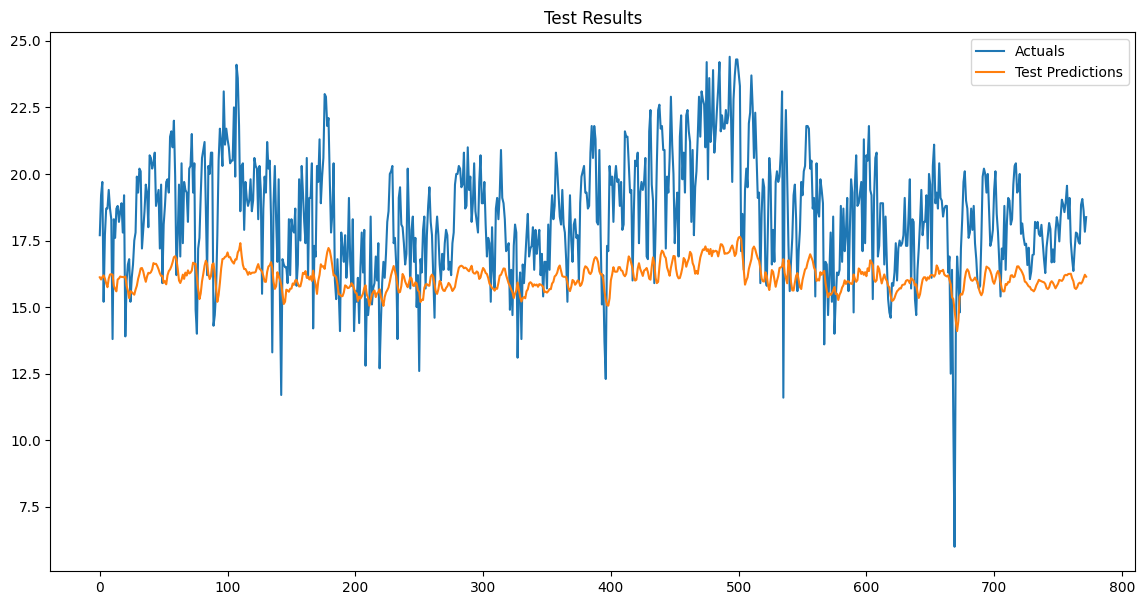

In [ ]:
# Graficar resultados de prueba
plt.figure(figsize=(14, 7))
plt.plot(test_results['Actuals'], label='Actuals')
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.title('Test Results')
plt.legend()
plt.show()

## EVALUATION

In [ ]:
#@title Función para graficar predicciones y calcular métricas
def plot_predictions1(model, X, y, scaler, start=0, end=800):
    predictions = model.predict(X).flatten()
    # Inversa de la transformación para obtener los valores reales
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_actual = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

    # Crear DataFrame con los valores predichos y reales
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y_actual})

    # Graficar
    plt.figure(figsize=(14, 7))
    plt.plot(df['Actuals'][start:end], label='Actuals')
    plt.plot(df['Predictions'][start:end], label='Predictions')
    plt.title(f'Predictions vs Actuals (Samples {start} to {end})')
    plt.legend()
    plt.show()

    # Calcular métricas
    test_mse = mse(y_actual, predictions)
    test_rmse = test_mse ** 0.5  # Calcular RMSE a partir de MSE
    test_mae = mae(y_actual, predictions)

    print(f"\nTest MSE: {test_mse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}\n")

    return df, test_mse, test_rmse, test_mae

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


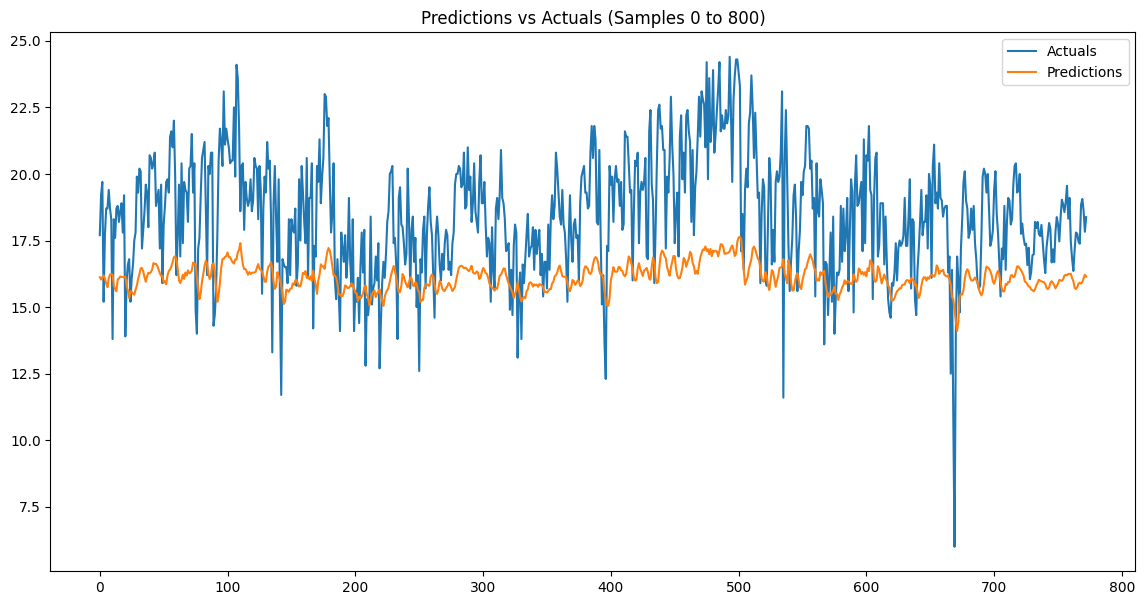


Test MSE: 9.3839
Test RMSE: 3.0633
Test MAE: 2.6145



In [ ]:
# Uso de la función para graficar
_, test_mse, test_rmse, test_mae = plot_predictions1(model1, X_test1, y_test1, scaler)

# **GRAPHICS**

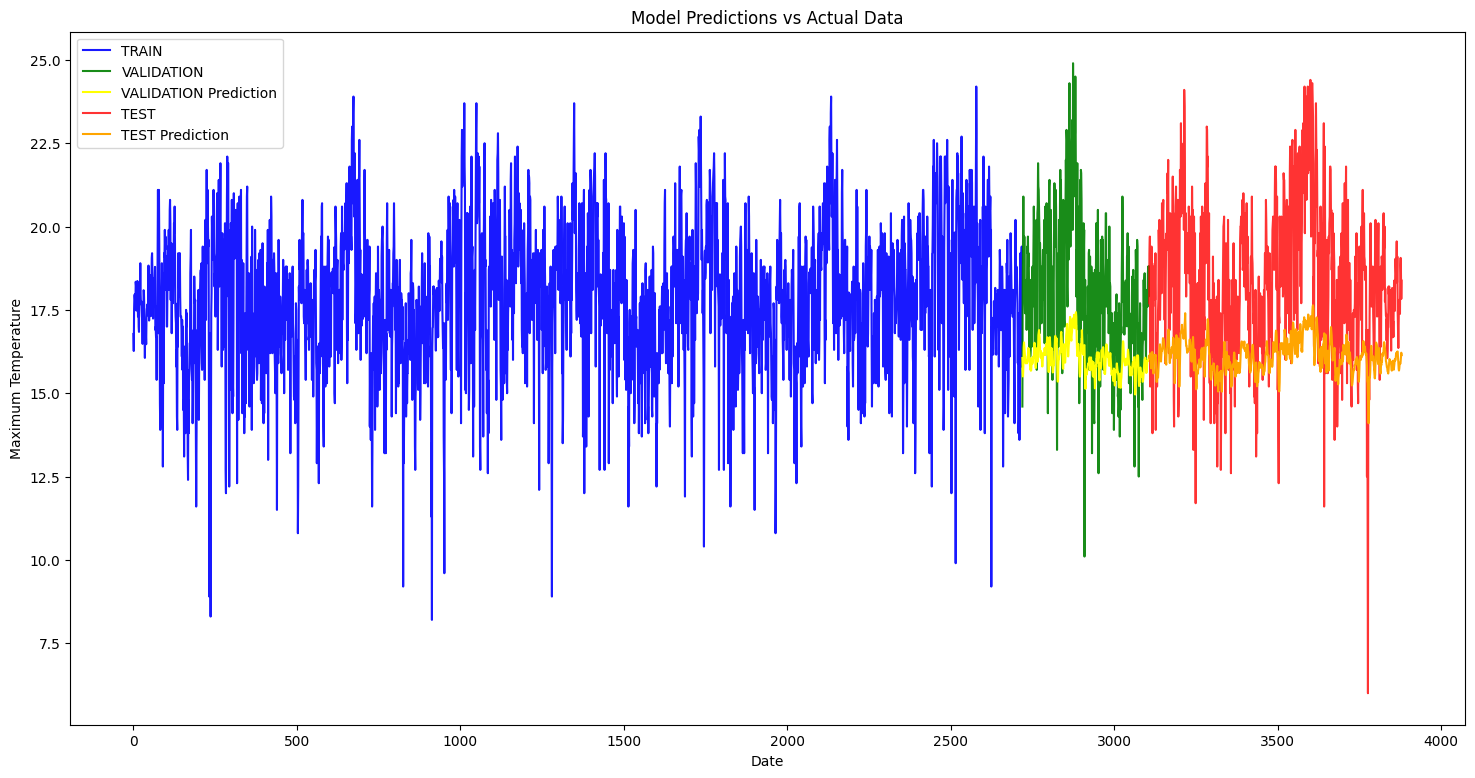

In [ ]:
# Asumimos que los conjuntos de datos están alineados secuencialmente.
# Obtenemos los índices totales para concatenar los conjuntos.
train_len = len(train_results)
val_len = len(val_results)
test_len = len(test_results)

# Gráficamos todo junto pero respetando el orden secuencial de los datos.
plt.figure(figsize=(18, 9))

# Datos de entrenamiento
plt.plot(range(train_len), train_results['Actuals'], label='TRAIN', color='blue', alpha=0.9)
# plt.plot(range(train_len), train_results['Train Predictions'], label='Train Predictions', linestyle='--', color='cyan')

# Datos de validación
plt.plot(range(train_len, train_len + val_len), val_results['Actuals'], label='VALIDATION', color='green', alpha=0.9)
plt.plot(range(train_len, train_len + val_len), val_results['Val Predictions'], label='VALIDATION Prediction', linestyle='-', color='yellow')

# Datos de prueba
plt.plot(range(train_len + val_len, train_len + val_len + test_len), test_results['Actuals'], label='TEST', color='red', alpha=0.8)
plt.plot(range(train_len + val_len, train_len + val_len + test_len), test_results['Test Predictions'], label='TEST Prediction', linestyle='-', color='orange')

plt.title('Model Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

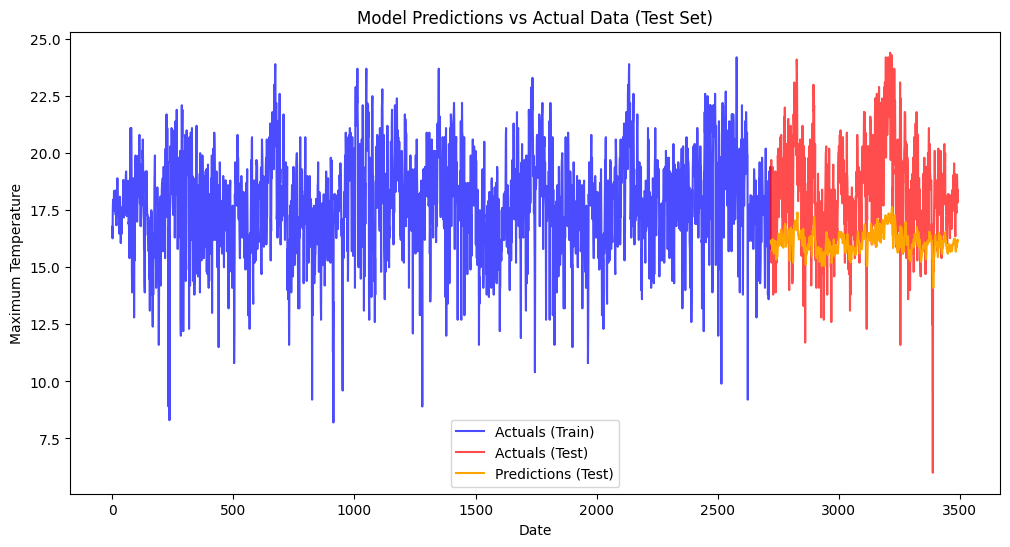

In [ ]:
# Supongamos que ya tienes tus resultados de entrenamiento y prueba.
# Obtener las longitudes de cada conjunto.
train_len = len(train_results)
test_len = len(test_results)

# Crear un gráfico de tamaño adecuado.
plt.figure(figsize=(12, 6))

# Graficar los datos de entrenamiento.
plt.plot(range(train_len), train_results['Actuals'], label='Actuals (Train)', color='blue', alpha=0.7)

# Graficar los datos de prueba.
plt.plot(range(train_len, train_len + test_len), test_results['Actuals'], label='Actuals (Test)', color='red', alpha=0.7)

# Graficar las predicciones sobre el conjunto de prueba.
plt.plot(range(train_len, train_len + test_len), test_results['Test Predictions'], label='Predictions (Test)', linestyle='-', color='orange')

# Añadir título y etiquetas de los ejes.
plt.title('Model Predictions vs Actual Data (Test Set)')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')

# Añadir la leyenda.
plt.legend()

# Mostrar el gráfico.
plt.show()

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


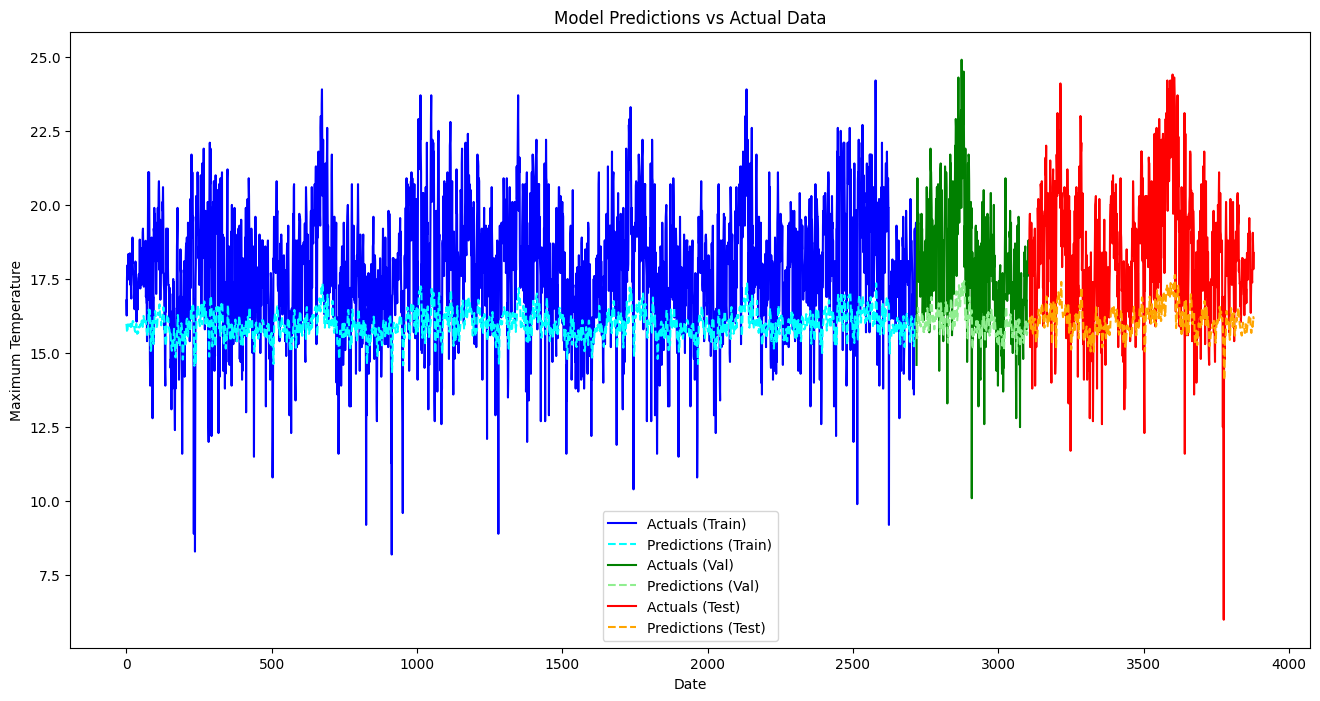

In [ ]:
import matplotlib.pyplot as plt

# Graficar resultados de entrenamiento, validación y prueba en un solo gráfico
plt.figure(figsize=(16, 8))

# Datos de entrenamiento
train_predictions = model1.predict(X_train1).flatten()
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
y_train_actual = scaler.inverse_transform(y_train1.reshape(-1, 1)).flatten()
plt.plot(range(len(y_train_actual)), y_train_actual, label='Actuals (Train)', color='blue')
plt.plot(range(len(train_predictions)), train_predictions, label='Predictions (Train)', linestyle='--', color='cyan')

# Datos de validación
val_predictions = model1.predict(X_val1).flatten()
val_predictions = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
y_val_actual = scaler.inverse_transform(y_val1.reshape(-1, 1)).flatten()
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_val_actual)), y_val_actual, label='Actuals (Val)', color='green')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(val_predictions)), val_predictions, label='Predictions (Val)', linestyle='--', color='lightgreen')

# Datos de prueba
test_predictions = model1.predict(X_test1).flatten()
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test1.reshape(-1, 1)).flatten()
plt.plot(range(len(y_train_actual) + len(y_val_actual), len(y_train_actual) + len(y_val_actual) + len(y_test_actual)), y_test_actual, label='Actuals (Test)', color='red')
plt.plot(range(len(y_train_actual) + len(y_val_actual), len(y_train_actual) + len(y_val_actual) + len(test_predictions)), test_predictions, label='Predictions (Test)', linestyle='--', color='orange')

plt.title('Model Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()